# Preliminary Fourier Analysis of Passive SONAR Array Data

In [39]:
# PREMISE 
# There is an acoustic pinger located some distance away from an autonomous submarine in some body of water. 
# The pinger pings at certain intervals, emitting a wave with x frequency and y amplitude. 
# The baseline amplitude is measured at a distance of z away from the pinger under ideal conditions. 
# The submarine has 4 hydrophones which are listening for pulses. They are a known distance away from each other in a certain configuration. 
# The data to the hydrophones must be used to figure out the autonomous submarine's position in relation to the acoustic pinger. 

# NOTES 
# Note that the data has been passed through first order high pass filter with a corner frequency of 50 Hz, 
# followed by an 8th order low pass filter with corner frequency of 50 kHz.

# FILES 
# ./SampleData1/1.csv is the primary file being used here. It corresponds to the first test of this sytem. It has 5 columns, the first four being 
# the discrete signals received by the hydrophone, and the last one being the index. 2.csv, 3.csv, and 4.csv, all located in sampleData1,
# are all also usable. 

# This file will use the csv data located in the file and conduct an analysis on it. 
# The csv file has 4 columns, which include sine wave data. 
# This data is from the following forum post: https://robonationforum.vbulletin.net/forum/robosub/-2020-robosub/3113-sample-hydrophone-data

# SPECIFICATIONS 
# Pinger Being Used: 
# Sampling Rate for Each Hydrophone: 250000 samples per second. 
# Hydrophones are located on the corners of a 15 mm square. Each side of the square is 15mm, so the positions of the hydrophones are as follows. 
# Hydrophone 1: (7.5 mm, 7.5 mm)
# Hydrophone 2: (-7.5 mm, 7.5 mm)
# Hydrophone 3: (-7.5 mm, -7.5 mm)
# Hydrophone 4: (7.5 mm, -7.5 mm)

In [40]:
# Classic Imports 
import pandas as pd
import numpy as np
from pathlib import Path

# Plotting Imports 

# Library FFT Imports 

# Custom
from wave_generator import create_wave

# ALL VARIABLES DEFINITION
samplingFrequency = 250000
dataFile = "./sampleData1/1.csv"
numSamplesToAnalyze = 4096

In [41]:
# The following code opens and looks at the first couple of rows of data from the csv. 

# The load_hydrophone_data function opens a CSV file. 
def load_hydrophone_data():
    return pd.read_csv(Path(dataFile), header = None)

hydrophoneData = load_hydrophone_data()
hydrophoneData.head()                                  # Gives first couple of lines of the csv

,0,1,2,3,4
0,-0.333863,-0.130310,0.581665,0.252381,0
1,-0.571900,-0.387574,0.679322,0.166931,1
2,-0.588379,-0.499878,0.295410,-0.138245,2
3,-0.431824,-0.582886,-0.359497,-0.449829,3
4,-0.288696,-0.663147,-0.852357,-0.590210,4


In [42]:
# Cleaning up the CSV File 
# This section of code simply adds a "time" column, and labels the columns correctly. 

def addTime(x): 
    return x / samplingFrequency

hydrophoneData.columns = ['hydrophone1', 'hydrophone2', 'hydrophone3', 'hydrophone4', 'time'] 
hydrophoneData["time"] = hydrophoneData["time"].apply(addTime)

hydrophoneData

,hydrophone1,hydrophone2,hydrophone3,hydrophone4,time
0,-0.333863,-0.130310,0.581665,0.252381,0.000000
1,-0.571900,-0.387574,0.679322,0.166931,0.000004
2,-0.588379,-0.499878,0.295410,-0.138245,0.000008
3,-0.431824,-0.582886,-0.359497,-0.449829,0.000012
4,-0.288696,-0.663147,-0.852357,-0.590210,0.000016
...,...,...,...,...,...
1048571,-0.208435,-0.254822,-0.172730,-0.195923,4.194284
1048572,-0.258484,-0.287476,-0.170593,-0.169678,4.194288
1048573,-0.295105,-0.243530,-0.176392,-0.206909,4.194292
1048574,-0.296631,-0.167847,-0.181885,-0.280152,4.194296


<AxesSubplot: xlabel='time'>

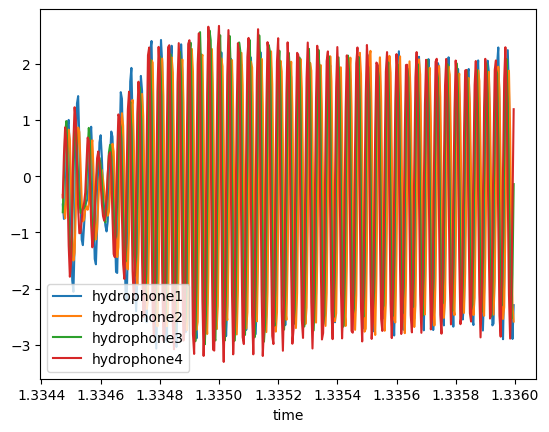

In [90]:
# Takes the first 30 samples from each of the hydrophones and stores them in sampleHydrophoneData for analysis. 
# These 30 samples are only used to see a visual plot of how the waves look like. It is not referenced later. 

# sampleHydrophoneData = hydrophoneData.iloc[333618:333625, :]
sampleHydrophoneData = hydrophoneData.iloc[333618:334000, :]
sampleHydrophoneData = pd.DataFrame(sampleHydrophoneData)

sampleHydrophoneData.plot(x = 'time')

In [89]:
sampleHydrophoneData

,hydrophone1,hydrophone2,hydrophone3,hydrophone4,time
333618,-0.504761,-0.333252,-0.642090,-0.379029,1.334472
333619,-0.761109,-0.608216,-0.022888,0.379639,1.334476
333620,-0.571900,-0.751648,0.746155,0.867921,1.334480
333621,0.145264,-0.386963,0.980836,0.650940,1.334484
333622,0.872498,0.336304,0.408325,-0.223999,1.334488
333623,1.001282,0.827637,-0.565491,-1.233521,1.334492
333624,0.326844,0.643921,-1.325685,-1.790162,1.334496


In [44]:
# Preparing for Fourier Analysis 
# This block of code gets the first 4096 lines of data from the first hydrophone, and stores it in the variable shortenedHydrophoneData. 
# Then, this array of data is analyzed by both the fft library from scipy, as well as a custom implementation of discrete fourier transform. 

shortenedHydrophoneData = hydrophoneData.iloc[:numSamplesToAnalyze, 0]
shortenedHydrophoneData = np.array(shortenedHydrophoneData)

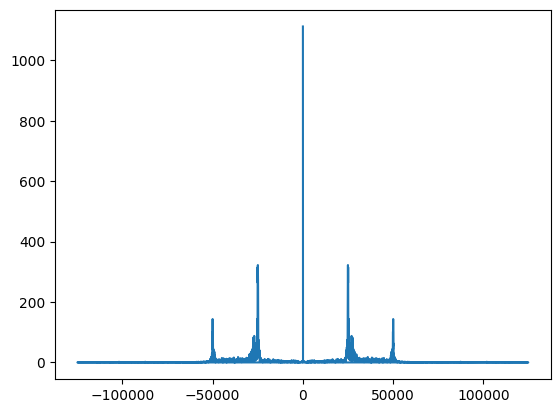

Using the scipy library, 4096 were analyzed in 0.043675899505615234seconds.


In [45]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
import time
start = time.time()

from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = numSamplesToAnalyze

yf = fft(shortenedHydrophoneData)
xf = fftfreq(N, 1 / samplingFrequency)

plt.plot(xf, np.abs(yf))
plt.show()

end = time.time()
print("Using the scipy library, " + str(numSamplesToAnalyze) + " were analyzed in " + str(end - start) + "seconds.")

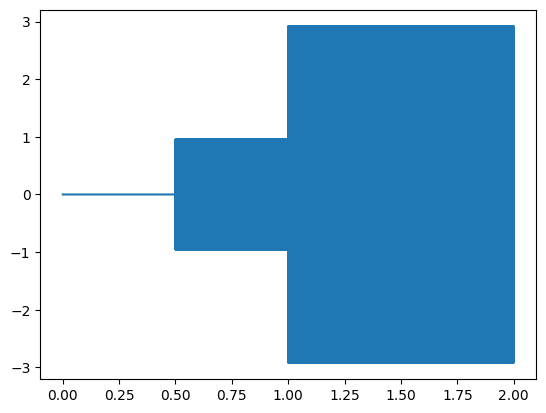

In [46]:
# Creating Sample Data to Analyze 

import math

# Parameters 
N = 1000000
sampling_frequency = 500000
sampling_time = N / sampling_frequency

# Time Array 
time_array = np.arange(N)
time_array = time_array / sampling_frequency

# The waveAdder is in the format of [frequency, magnitude, starting time]
waveAdder = [[50000, 1, 0.5], [20000, 2, 1]]

sample = np.zeros(N)

for wave in waveAdder:
    for i in range(N):
        if (i / sampling_frequency < wave[2]):
            sample[i] = sample[i] + 0
        else:
            sample[i] = sample[i] + wave[1] * np.sin(2 * math.pi * wave[0] * (i / sampling_frequency - wave[2]))

plt.plot(time_array, sample)

Text(0.5, 1.0, 'Discrete Fourier Transform')

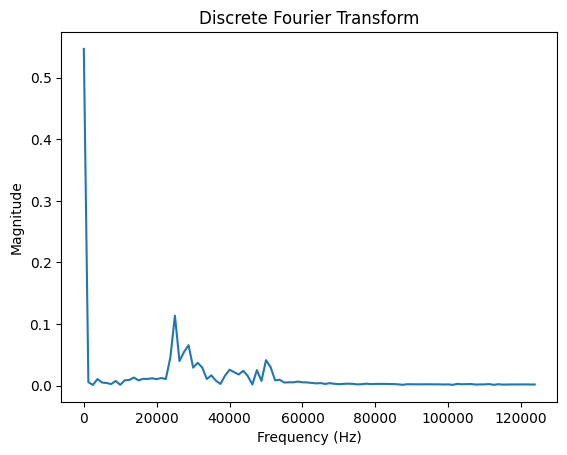

In [73]:
# DISCRETE FOURIER TRANSFORM (FROM SCRATCH)

import math
from matplotlib import pyplot as plt

N = 200                                        # Number of Samples 
sampling_freq = 250000                          # Sampling Frequency 
freq_resolution = sampling_freq / N             # Frequency Resolution 
data = shortenedHydrophoneData                  # Data in Array 

# # CUSTOM DATA (FROM MODULE ABOVE)
# N = 5000
# sampling_freq = 500000
# freq_resolution = sampling_freq / N
# data = sample[995000:]


# Example Data from Video (https://www.youtube.com/watch?v=mkGsMWi_j4Q)
# -------------------------------------------------------------------------------------
# N = 16                                                        # Number of Samples 
# sampling_freq = 8                                             # Sampling Frequency 
# freq_resolution = sampling_freq / N                           # Frequency Resolution 
# data = [0, 0.707, 1, 0.707, 0, -0.707, -1, -0.707,            # Data in Array 
#         0, 0.707, 1, 0.707, 0, -0.707, -1, -0.707]            
# -------------------------------------------------------------------------------------


# Creates a list of frequency bins 
bin_width = sampling_freq / N
frequency_bins = []

counter = 0
for i in range(N):
    frequency_bins.append(counter)
    counter = counter + bin_width

# Main Discrete Fourier Transform 
final_data = []

for i in range(N):
    real = 0
    complex = 0

    for j in range(N):
        real = real + data[j] * math.cos(-2 * math.pi * i * j / N)
        complex = complex + data[j] * math.sin(-2 * math.pi * i * j / N)
    
    temporary = [real, complex]
    final_data.append(temporary)

# Finds magnitude for each frequency bin and places into a new array
magnitude_array = []

for x in final_data: 
    magnitude = math.sqrt((x[0])**2 + (x[1])**2)
    magnitude_array.append(magnitude)

# Deals with the Nyquist Limit By Doubling the First Half of all Entries in 
# frequency_bins and magnitude_array. 

magnitude_array_nyquist = []
for x in range(len(magnitude_array) // 2):
    magnitude_array_nyquist.append((magnitude_array[x] * 2) / N)

frequency_bins_nyquist = []
for x in range(len(frequency_bins) // 2):
    frequency_bins_nyquist.append(frequency_bins[x])

# Plots the Magnitude for Each Frequency Bin 
plt.plot(frequency_bins_nyquist, magnitude_array_nyquist)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Discrete Fourier Transform")